# **IMPORTADO DE MÓDULOS/FUNCIONES**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d


from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from keras.regularizers import l2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import initializers
from keras.regularizers import l2
from keras.optimizers import Adam

import tensorflow as tf
tf.version.VERSION 

2024-06-12 12:50:36.343090: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-12 12:50:36.367124: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 12:50:36.756639: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'2.16.1'

In [2]:
V55 = np.load('/home/josea/Co60_5cm_5cm.npy')
V28 = np.load('/home/josea/Co60_2cm_8cm.npy')
V82 = np.load('/home/josea/Co60_8cm_2cm.npy')

In [3]:
from functions import gauss, gauss_fit, weights_definition, create_and_delay_pulse_pair, pulso, pulso_escalon, pulso_sigmoid, get_mean_pulse_from_set, momentos
from Models import model_definition_manual_weight_initialization,  Fit_to_exp_model, custom_loss, CustomOutputLayer, model_definition_convolutional

# **INTERPOLATION**

In [4]:
#--------------------------------Interpolar pulsos reales---------------------------------
input = V28
EXTRASAMPLING = 8
Nt = np.shape(input)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)

interp_func_V28 = interp1d(tiempo,V28, kind = 'cubic', axis = 1)
new_V28 = interp_func_V28(tiempo_new)

interp_func_V55 = interp1d(tiempo,V55, kind = 'cubic', axis = 1)
new_V55 = interp_func_V55(tiempo_new)

interp_func_V82 = interp1d(tiempo,V82, kind = 'cubic', axis = 1)
new_V82 = interp_func_V82(tiempo_new)


print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

Number of time points: 600
Time step: 0.20
New number of time points: 4800
New time step: 0.0250


In [5]:
#----------------------------- Start and stop points for pulse cropping -----------------
start = 50*EXTRASAMPLING
stop = 80*EXTRASAMPLING

#----------------------------- Create array of all positions ----------------------------
pulsos_reales = np.concatenate((new_V28,new_V55,new_V82), axis = 0)
print(pulsos_reales.shape)

(736, 4800, 2)


# **GENERATE MEAN PULSE PER DETECTOR**

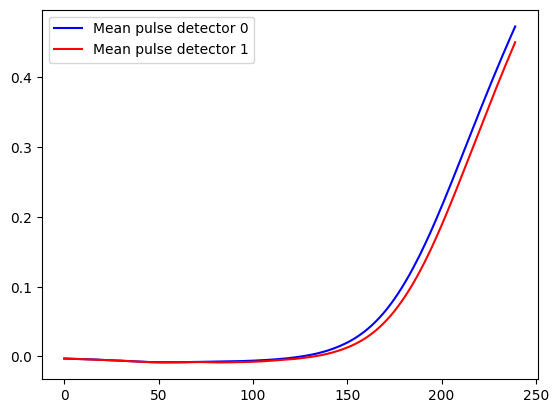

In [6]:
mean_pulse_dec0 = get_mean_pulse_from_set(new_V55, channel = 0)
mean_pulse_dec1 = get_mean_pulse_from_set(new_V55, channel = 1)

#-------------------------------------- Plot cropped mean pulses -----------------------------
plt.plot(mean_pulse_dec0[start:stop], 'b-', label = 'Mean pulse detector 0')
plt.plot(mean_pulse_dec1[start:stop], 'r-', label = 'Mean pulse detector 1')
plt.legend()

# **PREPROCESSING**

In [7]:
#------------------------------------- Basic definitions ----------------------------------------
Ncasos_sim = 0
Ncasos_real = int(pulsos_reales.shape[0])
Nc = 2

t = np.linspace(0,Nt,Nt_new)
#t0 = 65 + np.random.randint(5, size = Ncasos) 
t0 = 550 + np.random.randint(100, size = int(Ncasos_sim + Ncasos_real))
#t0 = 78 + np.random.randint(5, size = int(Ncasos_sim + Ncasos_real)) 

In [8]:
#--------------------------------- Detector 0 definitions -------------------------
tau_rise_dec0 = 3
tau_drop_dec0 = 150
Photon_yield = 100
center_window_dec0 = 0.3
rise_window_dec0 = 0.3

#--------------------------------- Detector 1 definitions -------------------------
tau_rise_dec1 = 3
tau_drop_dec1 = 150
Photon_yield = 100
center_window_dec1 = 0.3
rise_window_dec1 = 0.3

Text(0, 0.5, 'Voltage [A.U]')

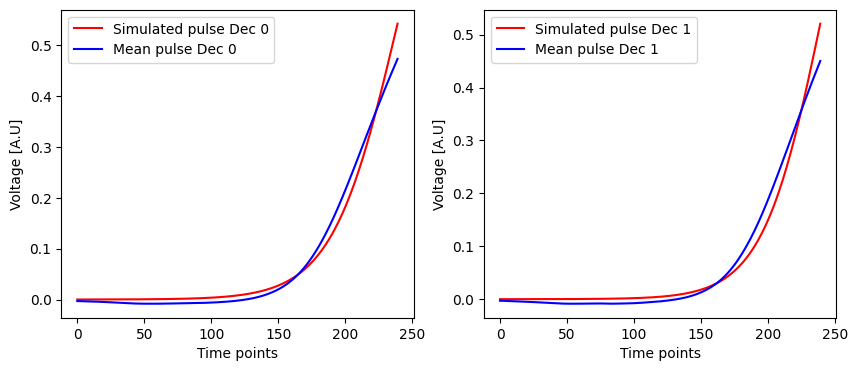

In [9]:
#pulso_original_dec0 = pulso(t, 70, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1)
#pulso_original_dec1 = pulso(t, 70, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1)
pulso_original_dec0 =  pulso_sigmoid(tiempo_new, 80, A = Photon_yield, center_window = center_window_dec0, rise_window = rise_window_dec0, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0, NOISE = False)
pulso_original_dec1 =  pulso_sigmoid(tiempo_new, 80, A = Photon_yield, center_window = center_window_dec1, rise_window = rise_window_dec1, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1, NOISE = True)

plt.figure(figsize = (10,4))
plt.subplot(121)
plt.plot(pulso_original_dec0[start:stop],'r-', label = 'Simulated pulse Dec 0')
plt.plot(mean_pulse_dec0[start:stop],'b-', label = 'Mean pulse Dec 0')
plt.legend()
plt.xlabel('Time points')
plt.ylabel('Voltage [A.U]')

plt.subplot(122)
plt.plot(pulso_original_dec1[start:stop],'r-', label = 'Simulated pulse Dec 1')
plt.plot(mean_pulse_dec1[start:stop],'b-', label = 'Mean pulse Dec 1')
plt.legend()
plt.xlabel('Time points')
plt.ylabel('Voltage [A.U]')

In [10]:
#------------------------------ Create simulated pulses ---------------------------------
INPUT_dec0 = np.zeros((Ncasos_sim,Nt_new))
INPUT_dec1 = np.zeros((Ncasos_sim,Nt_new))


for i in range(Ncasos_sim):
  centro = t0[i]
  #PULSO_dec0 = pulso(t, centro,  tau_rise = tau_rise_dec0)
  #PULSO_dec1 = pulso(t, centro, tau_rise = tau_rise_dec1)
  PULSO_dec0 = pulso_escalon(t, centro, A = 0.7)
  PULSO_dec1 = pulso_escalon(t, centro, A = 0.7)
  #PULSO_dec0 = pulso_sigmoid(tiempo_new, centro, A = Photon_yield, center_window = center_window_dec0, rise_window = rise_window_dec0, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0, NOISE = False)
  #PULSO_dec1 = pulso_sigmoid(tiempo_new, centro, A = Photon_yield, center_window = center_window_dec1, rise_window = rise_window_dec1, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1, NOISE = False)
  INPUT_dec0[i,:] = PULSO_dec0
  INPUT_dec1[i,:] = PULSO_dec1


In [11]:
#-------------------------------- Delay simulated pulses --------------------------------------------
INPUT_dec0, REF_dec0 = create_and_delay_pulse_pair(INPUT_dec0, new_time_step, delay_steps = 32, NOISE = True)
INPUT_dec1, REF_dec1 = create_and_delay_pulse_pair(INPUT_dec1, new_time_step, delay_steps = 32, NOISE = True)

#--------------------------------- Delay mean pulse ----------------------------------------------------
INPUT2_dec0, REF2_dec0 = create_and_delay_pulse_pair(pulsos_reales[:Ncasos_real,:,0], new_time_step, delay_steps = 32, NOISE = True)
INPUT2_dec1, REF2_dec1 = create_and_delay_pulse_pair(pulsos_reales[:Ncasos_real,:,1], new_time_step, delay_steps = 32, NOISE = True)

#--------------------------------- Create train set ----------------------------------------------------
trainX_dec0 = np.concatenate((INPUT_dec0[:,start:stop,:], INPUT2_dec0[:,start:stop,:]), axis = 0)
trainX_dec1 = np.concatenate((INPUT_dec1[:,start:stop,:], INPUT2_dec1[:,start:stop,:]), axis = 0)

REF_train_dec0 = np.concatenate((REF_dec0[:], REF2_dec0[:]))
REF_train_dec1 = np.concatenate((REF_dec1[:], REF2_dec1[:]))

<Axes: title={'center': 'Detector 1'}>

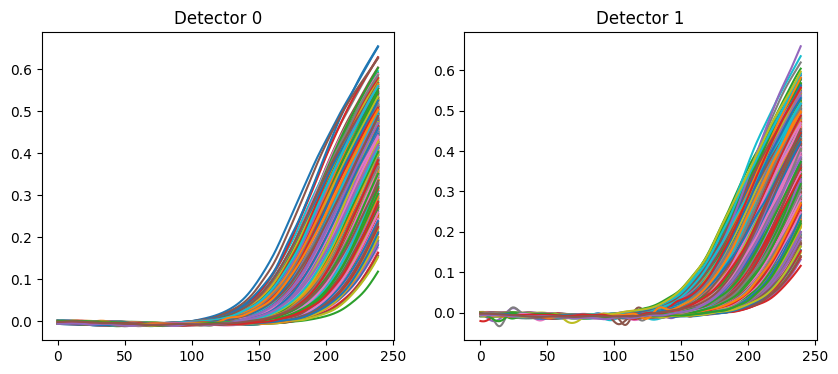

In [12]:
plt.figure(figsize = (10,4))

plt.subplot(121)
for i in range(trainX_dec0.shape[0]):
  plt.plot(trainX_dec0[i,:,0])
plt.title('Detector 0')
plt.subplot(122)
for i in range(trainX_dec1.shape[0]):
  plt.plot(trainX_dec1[i,:,0])
plt.title('Detector 1')
plt.subplot(122)


In [13]:
#--------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec0 = momentos(trainX_dec0)
M_Train_dec1 = momentos(trainX_dec1)

#------------------------------------------ Normalize -------------------------------------------------
min_dec0 = np.min(M_Train_dec0)
max_dec0 = np.max(M_Train_dec0)

min_dec1 = np.min(M_Train_dec1)
max_dec1 = np.max(M_Train_dec1)

M_Train_dec0 = (M_Train_dec0 - min_dec0)/(max_dec0 - min_dec0)
M_Train_dec1 = (M_Train_dec1 - min_dec1)/(max_dec1 - min_dec1)

#------------------------------------ Print Important information -----------------------------------------------
NM = np.shape(M_Train_dec0)[1]
print(M_Train_dec0.shape, "NM =", NM)
print('Min detector 0: ', min_dec0)
print('Max detector 0: ', max_dec0)

NM = np.shape(M_Train_dec1)[1]
print(M_Train_dec1.shape, "NM =", NM)
print('Min detector 1: ', min_dec1)
print('Max detector 1: ', max_dec1)

(736, 12, 2) NM = 12
Min detector 0:  -0.1313077903796862
Max detector 0:  37.87952816251623
(736, 12, 2) NM = 12
Min detector 1:  -0.1787473971984848
Max detector 1:  29.994103573962757


# **MULTIPLE TRAINING**

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

In [15]:
REFERENCE_PULSE_dec0 = np.tile(mean_pulse_dec0[start:stop], (new_V82.shape[0],2,1)).swapaxes(1,2)
REFERENCE_PULSE_dec1 = np.tile(mean_pulse_dec1[start:stop], (new_V82.shape[0],2,1)).swapaxes(1,2)

M_REF_dec0 = momentos(REFERENCE_PULSE_dec0)
M_REF_dec1 = momentos(REFERENCE_PULSE_dec1)
 
M_REF_dec0 = (M_REF_dec0 - min_dec0)/(max_dec0 - min_dec0)
M_REF_dec1 = (M_REF_dec1 - min_dec1)/(max_dec1 - min_dec1)

M_V55 = momentos(new_V55[:,start:stop,:])
M_V55[:,:,0] = (M_V55[:,:,0] - min_dec0)/(max_dec0-min_dec0)
M_V55[:,:,1] = (M_V55[:,:,1] - min_dec1)/(max_dec1-min_dec1)

M_V28 = momentos(new_V28[:,start:stop,:])
M_V28[:,:,0] = (M_V28[:,:,0] - min_dec0)/(max_dec0-min_dec0)
M_V28[:,:,1] = (M_V28[:,:,1] - min_dec1)/(max_dec1-min_dec1)

M_V82 = momentos(new_V82[:,start:stop,:])
M_V82[:,:,0] = (M_V82[:,:,0] - min_dec0)/(max_dec0-min_dec0)
M_V82[:,:,1] = (M_V82[:,:,1] - min_dec1)/(max_dec1-min_dec1)

In [16]:
# Create DataLoader for the prediction data
M_V82_tensor = torch.tensor(M_V82, dtype = torch.float32)
M_V55_tensor = torch.tensor(M_V55, dtype = torch.float32)
M_V28_tensor = torch.tensor(M_V28, dtype = torch.float32)

M_REF_dec0_tensor = torch.tensor(M_REF_dec0, dtype = torch.float32)
M_REF_dec1_tensor = torch.tensor(M_REF_dec1, dtype = torch.float32)


val_dataset_dec0_V82 = torch.utils.data.TensorDataset(M_V82_tensor[:,:,0], M_REF_dec0_tensor[:new_V82.shape[0],:,0])
val_dataset_dec0_V55 = torch.utils.data.TensorDataset(M_V55_tensor[:,:,0], M_REF_dec0_tensor[:new_V55.shape[0],:,0])
val_dataset_dec0_V28 = torch.utils.data.TensorDataset(M_V28_tensor[:,:,0], M_REF_dec0_tensor[:new_V28.shape[0],:,0])

val_loader_dec0_V82 = torch.utils.data.DataLoader(val_dataset_dec0_V82, batch_size = 32, shuffle = False)
val_loader_dec0_V55 = torch.utils.data.DataLoader(val_dataset_dec0_V55, batch_size = 32, shuffle = False)
val_loader_dec0_V28 = torch.utils.data.DataLoader(val_dataset_dec0_V28, batch_size = 32, shuffle = False)

val_dataset_dec1_V82 = torch.utils.data.TensorDataset(M_V82_tensor[:,:,1], M_REF_dec1_tensor[:new_V82.shape[0],:,0])
val_dataset_dec1_V55 = torch.utils.data.TensorDataset(M_V55_tensor[:,:,1], M_REF_dec1_tensor[:new_V55.shape[0],:,0])
val_dataset_dec1_V28 = torch.utils.data.TensorDataset(M_V28_tensor[:,:,1], M_REF_dec1_tensor[:new_V28.shape[0],:,0])

val_loader_dec1_V82 = torch.utils.data.DataLoader(val_dataset_dec1_V82, batch_size = 32, shuffle = False)
val_loader_dec1_V55 = torch.utils.data.DataLoader(val_dataset_dec1_V55, batch_size = 32, shuffle = False)
val_loader_dec1_V28 = torch.utils.data.DataLoader(val_dataset_dec1_V28, batch_size = 32, shuffle = False)

In [49]:
class ExpModel(nn.Module):
    def __init__(self, NM, NN = 32, STD_INIT = 1):
        super(ExpModel, self).__init__()
        self.dense1 = nn.Linear(NM, NN)
        self.dense2 = nn.Linear(NN, NN)
        self.dense3 = nn.Linear(NN, NN)
        self.dense4 = nn.Linear(NN, NN)
        self.output = nn.Linear(NN, 1)
        
        nn.init.normal_(self.dense1.weight, mean=0.0, std=STD_INIT)
        nn.init.normal_(self.dense2.weight, mean=0.0, std=STD_INIT)
        nn.init.normal_(self.dense3.weight, mean=0.0, std=STD_INIT)
        nn.init.normal_(self.dense4.weight, mean=0.0, std=STD_INIT)
        nn.init.normal_(self.output.weight, mean=0.0, std=STD_INIT)

    def forward(self, inputA, inputB):
        xA = torch.relu(self.dense1(inputA))
        xA = torch.relu(self.dense2(xA))
        xA = torch.relu(self.dense3(xA))
        xA = torch.relu(self.dense4(xA))
        outA = torch.relu(self.output(xA))
        
        xB = torch.relu(self.dense1(inputB))
        xB = torch.relu(self.dense2(xB))
        xB = torch.relu(self.dense3(xB))
        xB = torch.relu(self.dense4(xB))
        outB = torch.relu(self.output(xB))
        
        return outA, outB

    
def custom_loss(outA, outB, input_REF):
    loss1 = torch.mean((outA - outB - input_REF)**2)
    return loss1



def make_predictions(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():  # No need to compute gradients for prediction
        for inputA, inputB in data_loader:
            inputA, inputB = inputA.double(), inputB.double()
            outA, outB = model(inputA, inputB)
            predictions.append((outA, outB))
    return predictions

def process_predictions(predictions):
    outA_list, outB_list = [], []
    for outA, outB in predictions:
        outA_list.append(outA.numpy())
        outB_list.append(outB.numpy())
    outA_array = np.concatenate(outA_list, axis = 0)
    outB_array = np.concatenate(outB_list, axis = 0)
    return outA_array, outB_array




def train_model(model, optimizer, train_loader, val_loader1, val_loader2, val_loader3, epochs = 50):
    model.double()
    model.train()
    
    outA_V82_list = []
    outA_V55_list = []
    outA_V28_list = []

    for epoch in range(epochs):
        for inputA, inputB, input_REF in train_loader:
            optimizer.zero_grad()
            outA, outB = model(inputA, inputB)
            loss = custom_loss(outA, outB, input_REF)
            loss.backward()
            optimizer.step()
        
        predictions_V82 = make_predictions(model, val_loader1)
        predictions_V55 = make_predictions(model, val_loader2)
        predictions_V28 = make_predictions(model, val_loader3)
        
        outA_V82, outB_V82 = process_predictions(predictions_V82) 
        outA_V55, outB_V55 = process_predictions(predictions_V55)
        outA_V28, outB_V28 = process_predictions(predictions_V28)

    
        outA_V82_list.append(outA_V82)
        outA_V55_list.append(outA_V55)
        outA_V28_list.append(outA_V28)
        
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')
    
    outA_V82 = np.array(outA_V82_list, dtype = 'object')
    outA_V55 = np.array(outA_V55_list, dtype = 'object')
    outA_V28 = np.array(outA_V28_list, dtype = 'object')
    
    return outA_V82, outA_V55, outA_V28
    

In [56]:
# Assuming trainX_dec0, trainX_dec1, REF_train_dec0, and REF_train_dec1 are numpy arrays
M_Train_dec0 = torch.tensor(M_Train_dec0, dtype = torch.float64)
M_Train_dec1 = torch.tensor(M_Train_dec1, dtype = torch.float64)
REF_train_dec0 = torch.tensor(REF_train_dec0, dtype = torch.float64)
REF_train_dec1 = torch.tensor(REF_train_dec1, dtype = torch.float64)

# Create a DataLoader
train_dataset_dec0 = torch.utils.data.TensorDataset(M_Train_dec0[:,:,0], M_Train_dec0[:,:,1], REF_train_dec0)
train_loader_dec0 = torch.utils.data.DataLoader(train_dataset_dec0, batch_size = 32, shuffle = True)

train_dataset_dec1 = torch.utils.data.TensorDataset(M_Train_dec1[:,:,0], M_Train_dec1[:,:,1], REF_train_dec1)
train_loader_dec1 = torch.utils.data.DataLoader(train_dataset_dec1, batch_size = 32, shuffle = True)


# Instantiate the model, optimizer
model_dec0 = ExpModel(NM = NM, NN = 128, STD_INIT = 1)
model_dec1 = ExpModel(NM = NM, NN = 128, STD_INIT = 1)
optimizer_dec0 = optim.Adam(model_dec0.parameters(), lr = 5e-3)
optimizer_dec1 = optim.Adam(model_dec1.parameters(), lr = 5e-3)

# Train the model
outA_dec0_V82, outA_dec0_V55, outA_dec0_V28 = train_model(model_dec0, optimizer_dec0, train_loader_dec0, val_loader_dec0_V82, val_loader_dec0_V55, val_loader_dec0_V28, epochs = 500)
outA_dec1_V82, outA_dec1_V55, outA_dec1_V28 = train_model(model_dec1, optimizer_dec1, train_loader_dec1, val_loader_dec1_V82, val_loader_dec1_V55, val_loader_dec1_V28, epochs = 500)

/tmp/ipykernel_915252/3059160343.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  M_Train_dec0 = torch.tensor(M_Train_dec0, dtype = torch.float64)
/tmp/ipykernel_915252/3059160343.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  M_Train_dec1 = torch.tensor(M_Train_dec1, dtype = torch.float64)
/tmp/ipykernel_915252/3059160343.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  REF_train_dec0 = torch.tensor(REF_train_dec0, dtype = torch.float64)
/tmp/ipykernel_915252/3059160343.py:5: UserWarning: To copy construct from a tensor, it is

Epoch 1/500, Loss: 0.11570312140800529
Epoch 2/500, Loss: 0.13296875247557194
Epoch 3/500, Loss: 0.12763671882275962
Epoch 4/500, Loss: 0.13156249742489318
Epoch 5/500, Loss: 0.08439452954218728
Epoch 6/500, Loss: 0.11843750362284489
Epoch 7/500, Loss: 0.0998046882479685
Epoch 8/500, Loss: 0.07279296811087993
Epoch 9/500, Loss: 0.12666015728027566
Epoch 10/500, Loss: 0.12978515744034674
Epoch 11/500, Loss: 0.13486327891296251
Epoch 12/500, Loss: 0.07050781291327442
Epoch 13/500, Loss: 0.07427734128374147
Epoch 14/500, Loss: 0.09943359436758337
Epoch 15/500, Loss: 0.10230468859605031
Epoch 16/500, Loss: 0.09587890628434256
Epoch 17/500, Loss: 0.10365234352415433
Epoch 18/500, Loss: 0.15537109170109045
Epoch 19/500, Loss: 0.12476562646566894
Epoch 20/500, Loss: 0.11578125039464798
Epoch 21/500, Loss: 0.1290039057756076
Epoch 22/500, Loss: 0.10335937540861785
Epoch 23/500, Loss: 0.13960937378520621
Epoch 24/500, Loss: 0.13427734275464906
Epoch 25/500, Loss: 0.07523437413387007
Epoch 26/50

In [51]:
print(outA_dec0_V28.shape)

(500, 187, 1)


In [52]:
TOFN_V82 = np.squeeze(outA_dec0_V82) - np.squeeze(outA_dec1_V82)
TOFN_V55 = np.squeeze(outA_dec0_V55) - np.squeeze(outA_dec1_V55)
TOFN_V28 = np.squeeze(outA_dec0_V28) - np.squeeze(outA_dec1_V28)

TOFN_V82 = np.array(TOFN_V82, dtype = 'float64')
TOFN_V55 = np.array(TOFN_V55, dtype = 'float64')
TOFN_V28 = np.array(TOFN_V28, dtype = 'float64')

In [53]:
centroid_V28 = np.mean(TOFN_V28, axis = 1) - np.mean(TOFN_V55, axis = 1)
centroid_V82 = np.mean(TOFN_V82, axis = 1) - np.mean(TOFN_V55, axis = 1)
mean_error_centroid = (abs(centroid_V28 + 0.2) + abs(centroid_V82 - 0.2)) / 2
mean_std = (np.std(TOFN_V82, axis = 1) + np.std(TOFN_V55, axis = 1) + np.std(TOFN_V28, axis = 1)) / 3
epsilon = np.sqrt(mean_error_centroid**2 + mean_std**2)
print(np.where(epsilon == np.min(epsilon)), np.min(epsilon))

(array([370]),) 0.19451939322085052



V82: CENTROID(ns) = 0.020  FWHM(ns) = 0.033  std(ns) = 0.014
V55: CENTROID(ns) = -0.002  FWHM(ns) = 0.039  std(ns) = 0.017
V28: CENTROID(ns) = 0.010  FWHM(ns) = 0.044  std(ns) = 0.019


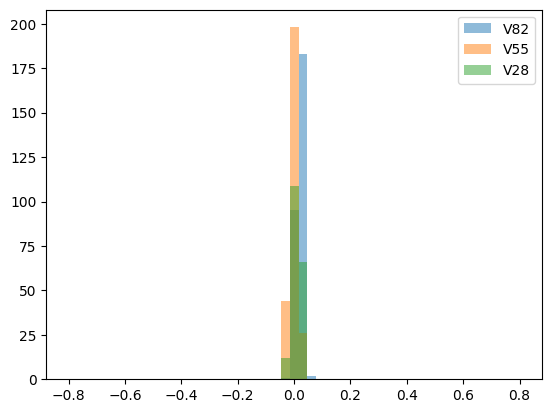

In [54]:
index = 370
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins = 51
histogN_V82, binsN, patchesN  = plt.hist(TOFN_V82[index,:] - np.mean(TOFN_V55[index,:]), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(TOFN_V55[index,:] - np.mean(TOFN_V55[index,:]), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(TOFN_V28[index,:] - np.mean(TOFN_V55[index,:]), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))